In [2]:
import glob
import numpy as np
import pandas as pd
from astropy.time import Time
import cdflib
import datetime
import spacepy.datamodel as dm
from astropy.table import Table
import math
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


gf = pd.read_csv('../data/processed/GF_ts_complete.csv')
gf['dates'] = (Time(gf['CDF Epoch'].values, format='cdf_epoch')).datetime


radar_bias = pd.read_csv('../data/processed/RADAR_CALIB_TEST.csv')
radar_bias['dates'] = (Time(radar_bias['cdf-epoch'].values, format='cdf_epoch')).datetime

gaps = pd.read_csv('../data/interim/GRACEFO/KBRNE_relative_v2/aux_files/GRACE-FO-GAP-BIAS.ARC',sep='\s+')
gaps = gaps[gaps['new_ARC'] == 1]
gaps = gaps.reset_index()




arc = []
radar_cdf_epoch = []
radar_name = []
radar_profiles = []
radar_ne = []
gf_ne = []

# create df with arc number
for i in iter(range(0, len(gaps))):
    try:
        idx = gf[gf['CDF Epoch'] == gaps['CDF_Epoch'][i]].index
        idy = gf[gf['CDF Epoch'] == gaps['CDF_Epoch'][i + 1]].index - 1

        radar_bias_mean = radar_bias[(radar_bias['cdf-epoch'] >= gaps['CDF_Epoch'][i]) & (
                    radar_bias['cdf-epoch'] < gaps['CDF_Epoch'][i + 1])]

        if len(radar_bias_mean) > 0:

            for j in iter(range(0, len(radar_bias_mean))):
                arc.append(i)
                radar_cdf_epoch.append(radar_bias_mean['cdf-epoch'][radar_bias_mean.index[j]])
                radar_name.append(radar_bias_mean['radar'][radar_bias_mean.index[j]])
                radar_profiles.append(radar_bias_mean['radar_nprofiles'][radar_bias_mean.index[j]])
                radar_ne.append(radar_bias_mean['radar_ne'][radar_bias_mean.index[j]])
                gf_ne.append(radar_bias_mean['gf_ne'][radar_bias_mean.index[j]])

    except:
        pass

GF_RADAR_CALIB = pd.DataFrame({'arc': arc,
                               'radar_cdf_epoch': radar_cdf_epoch,
                               'radar_name': radar_name,
                               'radar_profiles': radar_profiles,
                               'radar_ne': radar_ne,
                               'gf_ne': gf_ne})





# offset for each individual radar
GF_RADAR_CALIB['radar_offset'] = GF_RADAR_CALIB['radar_ne'] - GF_RADAR_CALIB['gf_ne']

# offset by arc
arcs_offset = GF_RADAR_CALIB.groupby(["arc"])["radar_offset"].mean()
arcs_offset_df = pd.DataFrame({'arc': arcs_offset.index,
                              'mean_offset': arcs_offset.values})
GF_RADAR_CALIB = pd.merge(GF_RADAR_CALIB, arcs_offset_df, on='arc')

# save csv
GF_RADAR_CALIB.to_csv('../data/processed/GF_RADAR_CALIB.csv')





# Time series with radar conjunctions

classes = ['EISCATSvalbardISRadarLongyearbyen', 'EISCATTromsoUHFISradar', 'EISCATTromsoVHFISradar',
           'MillstoneHillISRadar']




/Users/andyara/opt/anaconda3/envs/gfz_spacepy/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [42]:
%matplotlib widget

i = 33
idx = gf[gf['CDF Epoch'] == gaps['CDF_Epoch'][i]].index
idy = gf[gf['CDF Epoch'] == gaps['CDF_Epoch'][i + 1]].index - 1

fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(gf['dates'][idx.values[0]:idy.values[0]], gf['Relative_Ne'][idx.values[0]:idy.values[0]], 'gray', zorder=-1)

scatter = plt.scatter(radar_bias['dates'], radar_bias['radar_ne'],
                      c=radar_bias.radar.astype('category').cat.codes, cmap='gist_rainbow',
                      s=10,zorder=1)

fig.autofmt_xdate()
ax.set_xlim(gf['dates'][idx.values[0]], gf['dates'][idy.values[0]])
ax.set_ylim(-2e11, 4e11)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()
plt.xticks()
plt.yticks()

# plt.title('ARC {n}'.format(n=i))

plt.legend(handles=scatter.legend_elements()[0],
           labels=classes,
           title="RADAR", loc='upper right',fontsize='small' )

plt.xlabel('UT dates')
plt.ylabel('Ne')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Ne')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Ne')

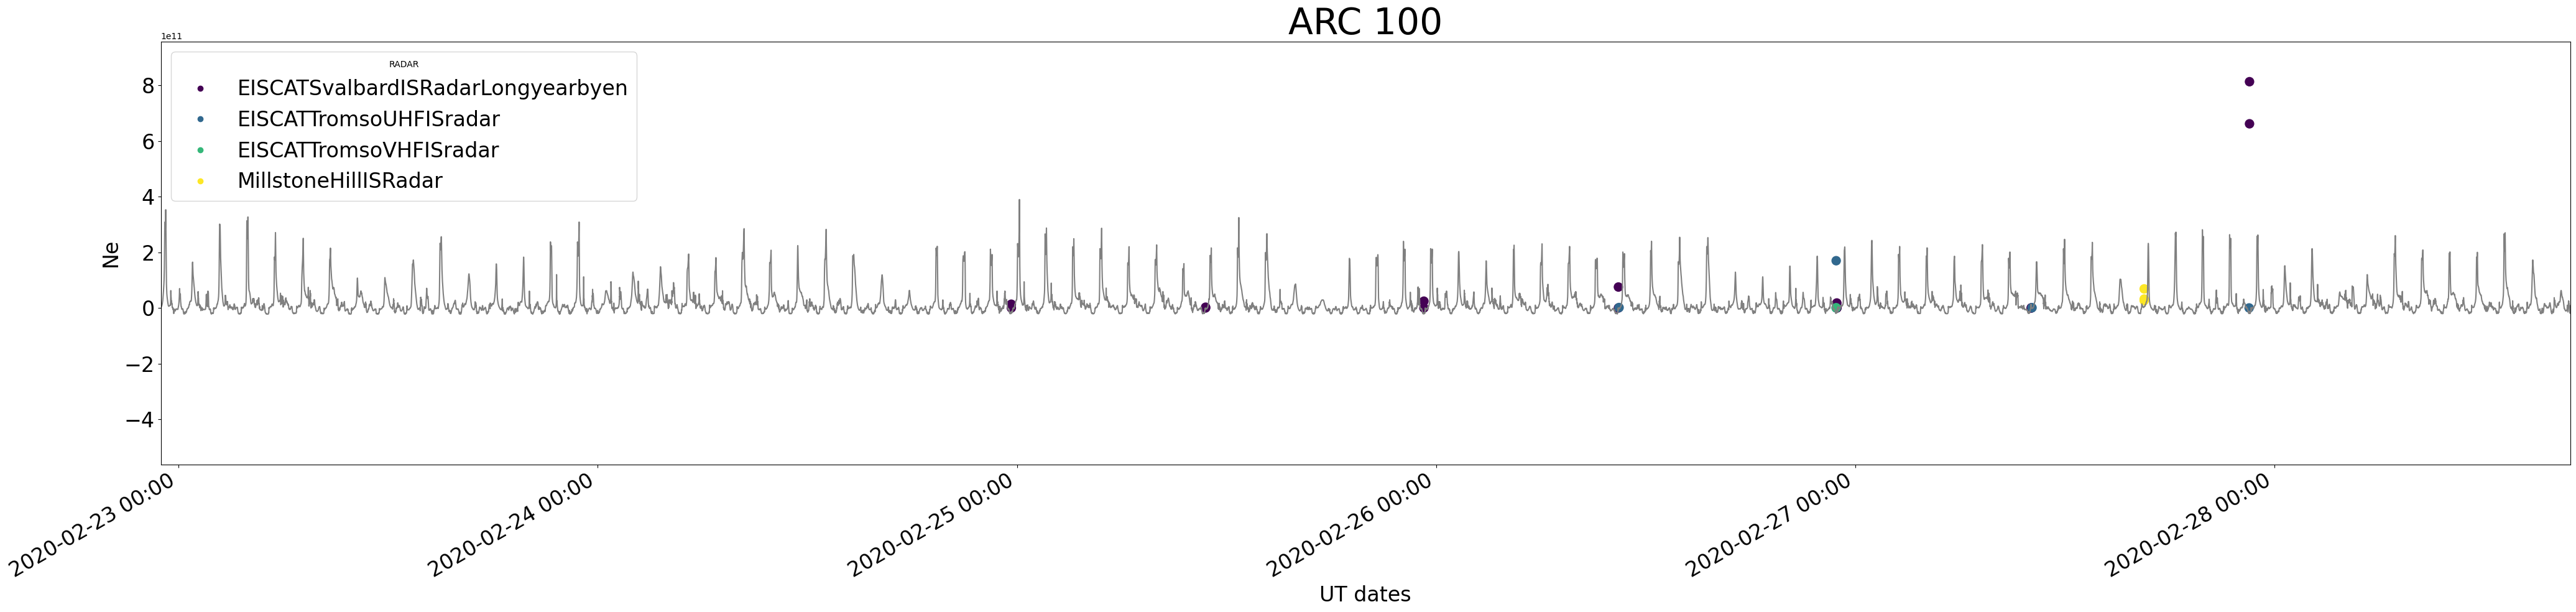

In [4]:
%matplotlib widget

i = 100
idx = gf[gf['CDF Epoch'] == gaps['CDF_Epoch'][i]].index
idy = gf[gf['CDF Epoch'] == gaps['CDF_Epoch'][i + 1]].index - 1

fig, ax = plt.subplots(figsize=(50, 10))
plt.plot(gf['dates'][idx.values[0]:idy.values[0]], gf['Relative_Ne'][idx.values[0]:idy.values[0]], 'gray')
scatter = plt.scatter(radar_bias['dates'], radar_bias['radar_ne'],
                      c=radar_bias.radar.astype('category').cat.codes, cmap='tab10'
                      s=100)

fig.autofmt_xdate()
ax.set_xlim(gf['dates'][idx.values[0]], gf['dates'][idy.values[0]])
ax.set_ylim(gf['Relative_Ne'].min(), 1.1 * gf['Relative_Ne'].max())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
fig.autofmt_xdate()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.title('ARC {n}'.format(n=i), fontsize=42)

plt.legend(handles=scatter.legend_elements()[0],
           labels=classes,
           title="RADAR",
           fontsize=24)

plt.xlabel('UT dates', fontsize=24)
plt.ylabel('Ne', fontsize=24)
